<h1><center>Fuel Efficiency Prediction Project</center><h1>

### Introduction
- This project aims to solve the fuel efficiency prediction of a car using regression model with Pytorch.

### Problem Definition
- Dataset: Auto MPG dataset, 70% train set, 20% validation set and 10% test set
- Each data contains the following features:

    1. Cylinder: numerical
    1. Displacement: numerical
    1. Horsepower: numerical
    1. Weight: numerical
    1. Acceleration: numerical
    1. ModelYear: numerical => ordered categorical to simplify the training
    1. Origin: unordered categorical => one-hot encoding

### 1. Dataset

In [64]:
import pandas as pd
import torch

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def generateCleanDataset() -> pd.DataFrame:
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    column = ["MPG", "Cylinder", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
    rawDataset =  pd.read_csv(url, names=column, na_values="?", comment="\t", sep=" ", skipinitialspace=True)

    return cleanDataset(rawDataset)

def cleanDataset(dataset:pd.DataFrame) -> pd.DataFrame:
    '''
        The raw dataset is cleaned by the following steps:
        1. Drop rows that contains NA values
        2. Normalize columns containing numerical values
        3. Use torch.bucketize to classify the model year into different groups (using default boundary)
    '''
    dataset = dropNARow(dataset)
    dataset = normaliseColumn(dataset)
    dataset = bucketizeColumn(dataset)

    return dataset

def dropNARow(dataset:pd.DataFrame) -> pd.DataFrame:
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop=True)

    return dataset

def normaliseColumn(dataset:pd.DataFrame) -> pd.DataFrame:
    column = ["Cylinder", "Displacement", "Horsepower", "Weight", "Acceleration"]
    dataset[column] = StandardScaler().fit_transform(dataset[column])

    return dataset

def bucketizeColumn(dataset:pd.DataFrame, boundary:list[int]=[73, 76, 79]) -> pd.DataFrame:
    boundary = torch.tensor(boundary)
    dataset["Model Year Bucket"] = torch.bucketize(torch.tensor(dataset["Model Year"], dtype=torch.uint8), boundary, right=True)

    return dataset

def convertDataFrameToTensor(dataset:pd.DataFrame) -> tuple[torch.Tensor, torch.Tensor]:
    '''
        Use one-hot encoding to process the unordered "Origin" column in the dataset
    '''
    featureColumn = ["Cylinder", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Model Year Bucket"] 
    outputColumn = ["MPG"]

    input = torch.cat(
        tensors = [
            torch.tensor(dataset[featureColumn].to_numpy()),
            oneHotEncodeColumn(dataset["Origin"])
        ],
        dim = 1
    ).float()
    label = torch.tensor(dataset[outputColumn].to_numpy()).float()

    return input, label

def oneHotEncodeColumn(column:pd.Series) -> torch.Tensor:
    return torch.nn.functional.one_hot(torch.from_numpy(column.values) % column.size)

def splitTrainValidationTest(dataset:pd.DataFrame, proportion:dict[str, float]={"Train":0.7, "Validation":0.2}) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    length = len(dataset)
    trainLength = int(length * proportion.get("Train"))
    validationLength = int(length * proportion.get("Validation"))

    train = dataset.iloc[:trainLength]
    validation = dataset.iloc[trainLength:trainLength+validationLength]
    test = dataset.iloc[trainLength+validationLength:]

    return train, validation, test

def generateDataLoader(dataset:pd.DataFrame, batchSize:int) -> DataLoader:
    '''
        By default, all dataloaders use shuffle=True for better performance
    '''
    input, label = convertDataFrameToTensor(dataset)

    return DataLoader(
        dataset = TensorDataset(input, label),
        batch_size = batchSize,
        shuffle = True
    )

dataset = generateCleanDataset()
print(dataset.head())

    MPG  Cylinder  Displacement  Horsepower    Weight  Acceleration  \
0  18.0  1.483947      1.077290    0.664133  0.620540     -1.285258   
1  15.0  1.483947      1.488732    1.574594  0.843334     -1.466724   
2  18.0  1.483947      1.182542    1.184397  0.540382     -1.648189   
3  16.0  1.483947      1.048584    1.184397  0.536845     -1.285258   
4  17.0  1.483947      1.029447    0.924265  0.555706     -1.829655   

   Model Year  Origin  Model Year Bucket  
0          70       1                  0  
1          70       1                  0  
2          70       1                  0  
3          70       1                  0  
4          70       1                  0  


### 2. Pytorch Model
- 3 linear layers (with ReLU activation function)

In [65]:
import torch
import torch.nn as nn

class RegressionModel(nn.Module):
    '''
        3 (Linear + ReLU)
    '''
    def __init__(self):
        super(RegressionModel, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(11, 7, bias=True),
            nn.ReLU(),
            nn.Linear(7, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, 1, bias=True)
        )
    
    def forward(self, input:torch.Tensor) -> torch.Tensor:
        return self.layer(input)

model = RegressionModel()
print(model)

RegressionModel(
  (layer): Sequential(
    (0): Linear(in_features=11, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


### 3. Train, Validation, Test and Evaluation

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import DataLoader

def train(
    epoch:int,
    trainDataLoader:DataLoader,
    validationDataLoader:DataLoader,
    model:RegressionModel,
    optimiser:Adam,
    loss:nn.MSELoss
) -> tuple[list[float], list[float]]:
    trainLoss, validationLoss= [], []

    for _ in range(epoch):
        startTime = time.time()

        model.eval()
        with torch.no_grad():
            validationLossEpoch = validateEpoch(validationDataLoader, model, loss)
            validationLoss.append(validationLossEpoch)
        
        model.train()
        trainLossEpoch = trainEpoch(trainDataLoader, model, optimiser, loss)
        trainLoss.append(trainLossEpoch)

        endTime = time.time()

        print(
            'Epoch : ',len(trainLoss), '\t',
            'Train Loss: ',np.format_float_scientific(trainLoss[-1], 3), '\t',
            "Validation Loss: ", np.format_float_scientific(validationLoss[-1], 3), '\t',
            'Time: ', "{:.3f}".format(endTime-startTime), "s")
    
    return trainLoss, validationLoss

def validateEpoch(validationDataLoader:DataLoader, model:RegressionModel, loss:nn.MSELoss) -> float:
    validationLossEpoch = 0

    for validationInputBatch, validationLabelBatch in validationDataLoader:
        validationLossEpoch = validateBatch(validationLossEpoch, validationInputBatch, validationLabelBatch, model, loss)
    
    return validationLossEpoch / len(validationDataLoader)

def validateBatch(
    validationLossEpoch:float,
    validationInputBatch:torch.Tensor,
    validationLabelBatch:torch.Tensor,
    model:RegressionModel,
    loss:nn.MSELoss
) -> float:
    prediction = model.forward(validationInputBatch)

    validationLossBatch = loss(prediction, validationLabelBatch)
    validationLossEpoch += validationLossBatch.item()

    return validationLossEpoch

def trainEpoch(trainDataLoader:DataLoader, model:RegressionModel, optimiser:Adam, loss:nn.MSELoss) -> float:
    trainLossEpoch = 0

    for trainInputBatch, trainLabelBatch in trainDataLoader:
        trainLossEpoch = trainBatch(trainLossEpoch, trainInputBatch, trainLabelBatch, model, optimiser, loss)
    
    return trainLossEpoch / len(trainDataLoader)

def trainBatch(
    trainLossEpoch:float,
    trainInputBatch:torch.Tensor,
    trainLabelBatch:torch.Tensor,
    model:RegressionModel,
    optimiser:Adam,
    loss:nn.BCELoss
) -> tuple[float, float]:
    prediction = model.forward(trainInputBatch)

    optimiser.zero_grad()
    trainLossBatch = loss(prediction, trainLabelBatch)
    trainLossBatch.backward()
    optimiser.step()

    trainLossEpoch += trainLossBatch.item()

    return trainLossEpoch

def test(testDataLoader:DataLoader, model:RegressionModel, loss:nn.MSELoss):
    testLoss = 0

    model.eval()
    with torch.no_grad():
        for testDataBatch, testLabelBatch in testDataLoader:
            testLoss = validateBatch(testLoss, testDataBatch, testLabelBatch, model, loss)

    print("Test Loss: ", np.format_float_scientific(testLoss / len(testDataLoader), 3), '\t')

def evaluate(
    trainLoss:list[float],
    validationLoss:list[float],
):
    figure = plt.figure(figsize=(8, 6), dpi=300)

    plt.plot(trainLoss, label="Train Loss", lw=2)
    plt.plot(validationLoss, label="Validaiton Loss", lw=2)

    plt.xlabel("Epoch")
    plt.ylabel("Train/Validaiton Loss")
    plt.legend()

    plt.show()

### 4. Experiment
- Epoch: 500
- Batch Size: 2, the size of the dataset is too small => requires a small batch size for more gradient calculation and update
- Learning Rate: 3e-3, try a small learning rate first to work with a small batch size
- Optimizer: Adam, auto adapted learning rate for better training process
- Loss: Mean Square Loss, very suitable for regression tasks as it is easy to find the gradient
- Device: CPU, the data size is relatively small

Epoch :  1 	 Train Loss:  3.275e+02 	 Validation Loss:  7.957e+02 	 Time:  0.310 s
Epoch :  2 	 Train Loss:  2.294e+02 	 Validation Loss:  6.550e+02 	 Time:  0.286 s
Epoch :  3 	 Train Loss:  1.319e+02 	 Validation Loss:  4.699e+02 	 Time:  0.290 s
Epoch :  4 	 Train Loss:  6.410e+01 	 Validation Loss:  2.967e+02 	 Time:  0.270 s
Epoch :  5 	 Train Loss:  3.853e+01 	 Validation Loss:  1.713e+02 	 Time:  0.273 s
Epoch :  6 	 Train Loss:  3.350e+01 	 Validation Loss:  1.218e+02 	 Time:  0.287 s
Epoch :  7 	 Train Loss:  3.162e+01 	 Validation Loss:  1.056e+02 	 Time:  0.281 s
Epoch :  8 	 Train Loss:  3.018e+01 	 Validation Loss:  1.007e+02 	 Time:  0.279 s
Epoch :  9 	 Train Loss:  2.898e+01 	 Validation Loss:  9.716e+01 	 Time:  0.273 s
Epoch :  10 	 Train Loss:  2.766e+01 	 Validation Loss:  9.112e+01 	 Time:  0.258 s
Epoch :  11 	 Train Loss:  2.634e+01 	 Validation Loss:  9.073e+01 	 Time:  0.269 s
Epoch :  12 	 Train Loss:  2.512e+01 	 Validation Loss:  8.818e+01 	 Time:  0.359 s
E

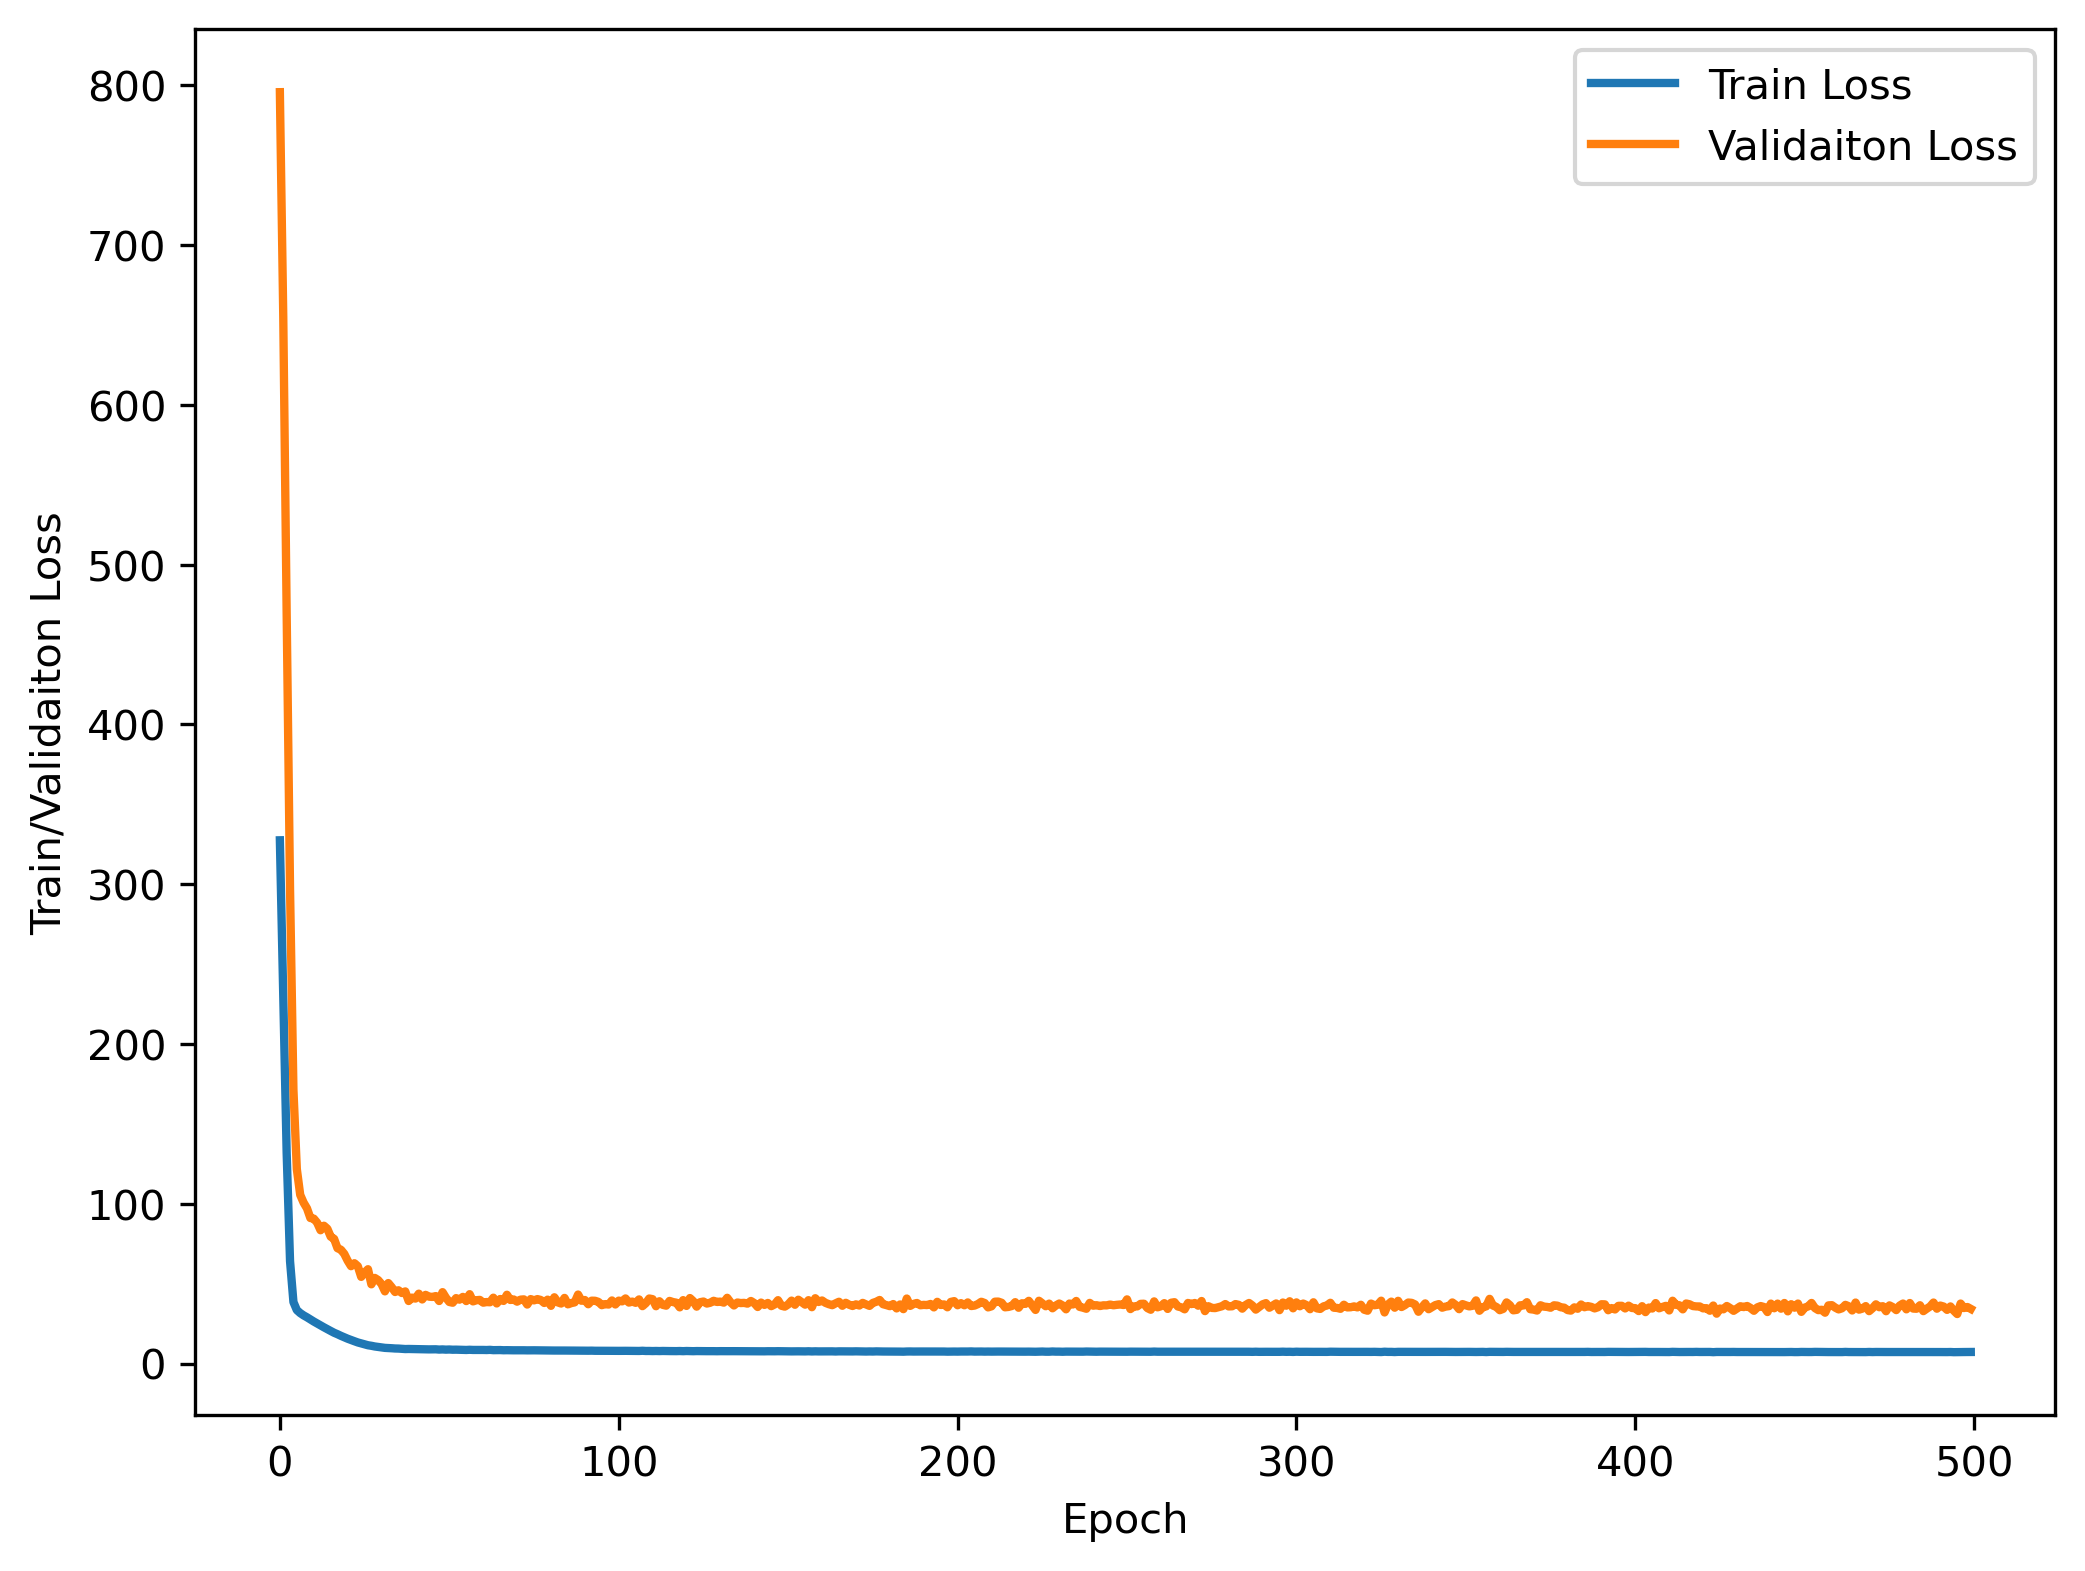

In [67]:
epoch = 500
batchSize = 2
learningRate = 3e-4
model = RegressionModel()
optimiser = Adam(model.parameters(), learningRate, (0.9, 0.99))
loss = nn.MSELoss()

trainDataset, validationDataset, testDataset = splitTrainValidationTest(generateCleanDataset())
trainDataLoader, validationDataLoader, testDataLoader = generateDataLoader(trainDataset, batchSize), generateDataLoader(validationDataset, batchSize), generateDataLoader(testDataset, batchSize)

trainLoss, validationLoss = train(epoch, trainDataLoader, validationDataLoader, model, optimiser, loss)
print(" ")
print("----------")
print(" ")
test(testDataLoader, model, loss)
evaluate(trainLoss, validationLoss)